In [1]:
import os, sys
PROJECT_ROOT = r"C:\Users\keshav bansal\PycharmProjects\PythonProject2\Satellite-Imagery-Based-Property-Valuation"
os.chdir(PROJECT_ROOT)
sys.path.append(PROJECT_ROOT)


In [2]:
import os, sys
PROJECT_ROOT = r"C:\Users\keshav bansal\PycharmProjects\PythonProject2\Satellite-Imagery-Based-Property-Valuation"
os.chdir(PROJECT_ROOT)
sys.path.append(PROJECT_ROOT)


In [3]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms

from src.models import MultimodalRegressor


In [5]:
# Tabular feature list (same as Part 5)
features = [
    "bedrooms", "bathrooms", "sqft_living_capped", "sqft_lot",
    "floors", "waterfront", "view", "condition", "grade",
    "lat", "long", "house_age", "bathroom_per_bedroom"
]


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MultimodalRegressor(tabular_dim=len(features)).to(device)
dummy_tabular = torch.zeros((1, len(features))).to(device)
model.eval()


MultimodalRegressor(
  (image_encoder): ImageEncoder(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [54]:
img_path = "images/train/1789.png"


In [55]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)


In [56]:
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])


In [57]:
target_layer = model.image_encoder.cnn.layer4
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)


In [58]:
dummy_tabular = torch.zeros((1, len(features))).to(device)

output = model(input_tensor, dummy_tabular)


In [59]:
model.zero_grad()
output.backward()


In [60]:
# Get captured data
acts = activations[0].detach()
grads = gradients[0].detach()

# Global average pooling on gradients
weights = grads.mean(dim=(2, 3), keepdim=True)

# Weighted sum
cam = (weights * acts).sum(dim=1)

# ReLU
cam = torch.relu(cam)

# Normalize
cam = cam.squeeze().cpu().numpy()
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)


In [61]:
heatmap = cv2.resize(cam, (256, 256))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

original = np.array(image.resize((256, 256)))
overlay = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)


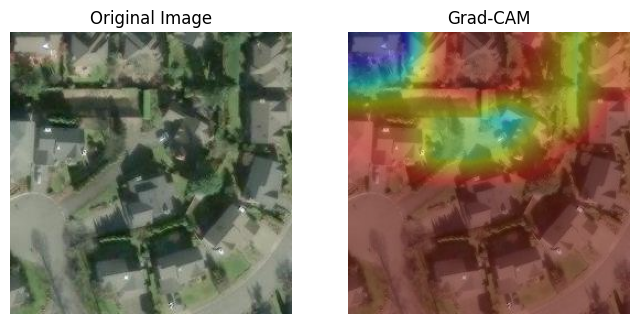

In [62]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(original)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Grad-CAM")
plt.imshow(overlay)
plt.axis("off")

plt.show()
